Epoch:0/101 Error_train:2.324467258646055 Error_test:2.3243559926984725
Epoch:10/101 Error_train:0.0051358602610137695 Error_test:0.05962437469393102
Epoch:20/101 Error_train:0.003888931916812126 Error_test:0.048666654731061264
Epoch:30/101 Error_train:0.0010182820508551661 Error_test:0.0056977745757519896
Epoch:40/101 Error_train:8.895188790868524e-05 Error_test:0.07476590415258713
Epoch:50/101 Error_train:2.8832618322248675e-05 Error_test:0.05198941712666692
Epoch:60/101 Error_train:1.458322452730359e-05 Error_test:0.09715849322934206
Epoch:70/101 Error_train:2.843480393142181e-07 Error_test:0.021733970480644293
Epoch:80/101 Error_train:4.18043653412664e-07 Error_test:0.0212122333969404
Epoch:90/101 Error_train:1.9895523940220083e-06 Error_test:0.07668571817264397
Epoch:100/101 Error_train:2.4728306175794856e-06 Error_test:0.1923489697708149


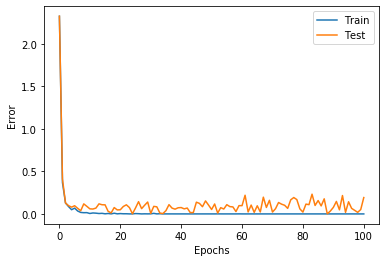

Accuracy Train: 100.0% Accuracy Test: 98.49749582637729%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


#手書き文字データセットの読み込み
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

#入力データの標準化
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

#正解をonehot表現化
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0


#訓練データとテストデータ
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]      #訓練入力
correct_train = correct_data[index_train, :]  #訓練正解
input_test = input_data[index_test, :]        #テスト入力
correct_test = correct_data[index_test, :]    #テスト正解

n_train = input_train.shape[0] #訓練データのサンプル数
n_test = input_test.shape[0]   #テストデータのサンプル数


#各設定値
img_h = 8   #入力画像高さ
img_w = 8   #入力画像幅
img_ch = 1  #入力画像チャンネル数

wb_width = 0.1 #重みとバイアスの広がり具合
eta = 0.01          #RMSPropの学習係数
p = 0.9               #RMSPropの忘却係数
epoch = 101        #エポック数
batch_size = 8   #バッチサイズ
interval = 10      #経過の表示間隔
n_sample = 200 #誤差計測のサンプル数



#im2col
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad,pad), (pad,pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + stride * out_h
        for w in range(flt_w):
            w_lim = w + stride * out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]
            
    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch * flt_h * flt_w, n_bt * out_h * out_w)
    return cols


#col2im
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride * out_h
        for w in range(flt_w):
            w_lim = w + stride*out_h
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]
            
    return images[:, :, pad:img_h+pad, pad:img_w+pad]



#畳み込み層
class ConvLayer:
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):
        
        #パラメータ
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        #フィルタとバイアスの初期値
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        self.y_ch = n_flt  #出力チャンネル数
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  #出力高さ
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  #出力幅
        
        #AdaGrad用
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8

    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        #入力画像とフィルタを行列変換
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        #出力の計算:行列積、バイアス、活性化関数
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, self.u*0.001, self.u)  #LeakyReLU
        
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        #delta
        delta = grad_y * np.where(self.u <= 0, 0.001, 1) #LeakyReLUの微分
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        #フィルタとバイアスの勾配
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        #入力の勾配
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta, p):
        #RMSProp
        self.h_w = (self.h_w * p) + ((1 - p) * self.grad_w * self.grad_w)
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b = (self.h_b * p) + ((1 - p) * self.grad_b * self.grad_b)
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

        
#プーリング層
class PoolingLayer:
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        #パラメータ
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        self.y_ch = x_ch  #出力チャンネル数
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  #出力高さ
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  #出力幅
       
    def forward(self,x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        #入力画像を行列変換
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        #出力の計算:MAXプーリング層
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        #最大値のインデックスを保存
        self.max_index = np.argmax(cols, axis=1)   
        
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        #出力の勾配の軸を入れ替える
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        #行列を作成
        grad_cols = np.zeros((pool*pool, grad_y.size))
        #各列の最大値に出力の勾配を入れる
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1)
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4)
        grad_cols = grad_cols.reshape(y_ch*pool*pool, n_bt*y_h*y_w)
        
        #入力の勾配
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

        
        
#全結合層
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        
        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta, p):
        #ADAGrad
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b +=  self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
                

#全結合層-中間層
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <=0, 0, self.u)  #ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1) #ReLUの微分
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
        
#全結合層-出力層
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u),axis=1).reshape(-1, 1)  #ソフトマックス関数
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

        

# -- ドロップアプト --
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio

    def forward(self, x, is_train):        
        if is_train:
            rand = np.random.rand(*x.shape)
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1-self.dropout_ratio)*x
        
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout
        


#各層の初期化
# -- 各層の初期化 --
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
cl_2 = ConvLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 10, 3, 3, 1, 1)
pl_1 = PoolingLayer(cl_2.y_ch, cl_2.y_h, cl_2.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = MiddleLayer(n_fc_in, 200)
dr_1 = Dropout(0.5)

ml_2 = MiddleLayer(200, 200)
dr_2 = Dropout(0.5)

ol_1 = OutputLayer(200, 10)


#順伝播
def forward_propagation(x, is_train):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    cl_2.forward(cl_1.y)
    pl_1.forward(cl_2.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)
    ml_1.forward(fc_input)
    dr_1.forward(ml_1.y, is_train)
    ml_2.forward(dr_1.y)
    dr_2.forward(ml_2.y, is_train)
    ol_1.forward(dr_2.y)

#逆伝播
def back_propagation(t):
    n_bt = t.shape[0]

    ol_1.backward(t)
    dr_2.backward(ol_1.grad_x)
    ml_2.backward(dr_2.grad_x)
    dr_1.backward(ml_2.grad_x)
    ml_1.backward(dr_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_2.backward(pl_1.grad_x)
    cl_1.backward(cl_2.grad_x)

    
#重みとバイアスの更新
def uppdate_wb():
    cl_1.update(eta, p)
    cl_2.update(eta, p)
    ml_1.update(eta, p)
    ml_2.update(eta, p)
    ol_1.update(eta, p)
    
    
#交差エントロピー誤差の計算
def get_error(t,batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size


#サンプルを順伝播
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand)
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x, False)
    return x, t


#-誤差の記録-
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

#学習と経過の記録
n_batch = n_train // batch_size  #1エポック当たりのバッチ数
for i in range(epoch):
    
    #誤差の計測
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    x, t = forward_sample(input_test, correct_test, n_sample)
    error_test = get_error(t, n_sample)
    
    #誤差の記録
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    #経過の表示
    if i%interval == 0:
        print("Epoch:"+ str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
        
        
    #-学習-
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)
    
    for j in range(n_batch):
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        forward_propagation(x, True)
        back_propagation(t)
        uppdate_wb()
        
        
        
#学習結果の表示
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

#正解率の測定
x, t = forward_sample(input_train, correct_train, n_train)
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test)
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
         "Accuracy Test:", str(count_test/n_test*100) + "%")

Input index number : 25
Result: [2]
Answer: [2]


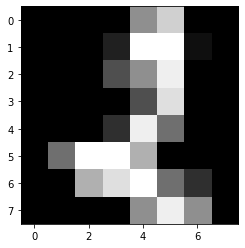

In [8]:
import matplotlib.image as mpimg

#[]内にコンマ区切りで整数を入れる
inp = input("Input index number : ")
a = np.array([int(inp)])

X = np.size(a)
for i in range(X):
    plt.figure()
    plt.imshow(input_test[a[i]].reshape(8,8),cmap="gray")
    
samples = input_test[a]
forward_propagation(samples, False)
print("Result: " + str(np.argmax(ol_1.y, axis=1)))
print("Answer: " + str(np.argmax(correct_test[a], axis=1)))

#i = np.argmax(ol_1.y, axis=1)
#print(ol_1[i].y)